In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image as im

In [2]:
def convolution3d(image, kernel, stride=1, padding=0):
    # Asumsikan gambar selalu memiliki 3 channel (RGB)
    channels = 3

    # Tambahkan padding ke gambar jika diperlukan
    if padding > 0:
        image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    # Ukuran output array perlu disesuaikan dengan ukuran hasil konvolusi
    output_height = (image.shape[0] - kernel.shape[0]) // stride + 1
    output_width = (image.shape[1] - kernel.shape[1]) // stride + 1
    output = np.zeros((output_height, output_width, channels))

    # Perulangan untuk menggeser kernel dan mengaplikasikan konvolusi ke setiap channel RGB
    for c in range(channels):  # Loop melalui setiap channel (R, G, B)
        for i in range(output_height):
            for j in range(output_width):
                conv = 0  # Reset nilai konvolusi setiap kali kernel dipindahkan
                # Mengambil bagian gambar yang sesuai dengan ukuran kernel
                for k in range(kernel.shape[0]):
                    for l in range(kernel.shape[1]):
                        # Posisi pada gambar dengan pergeseran `i`, `j`, `stride`, dan padding
                        x = i * stride + k
                        y = j * stride + l
                        if x < image.shape[0] and y < image.shape[1]:  # Pastikan dalam batas
                            conv += kernel[k, l] * image[x, y, c]  # Terapkan ke channel yang sesuai (R, G, atau B)
                output[i, j, c] = conv  # Simpan hasil konvolusi di channel yang sesuai
    
    return output

kernel_sharpen = np.array([[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]])


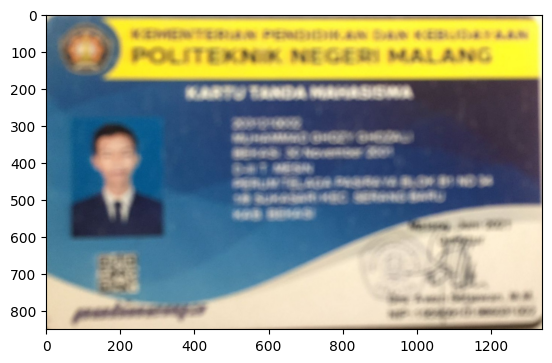

In [3]:
KTM = cv2.imread("3C_2041720257_4 - Lian Mega Pertiwi.jpg")
KTM = cv2.cvtColor(KTM, cv2.COLOR_BGR2RGB)
plt.imshow(KTM)

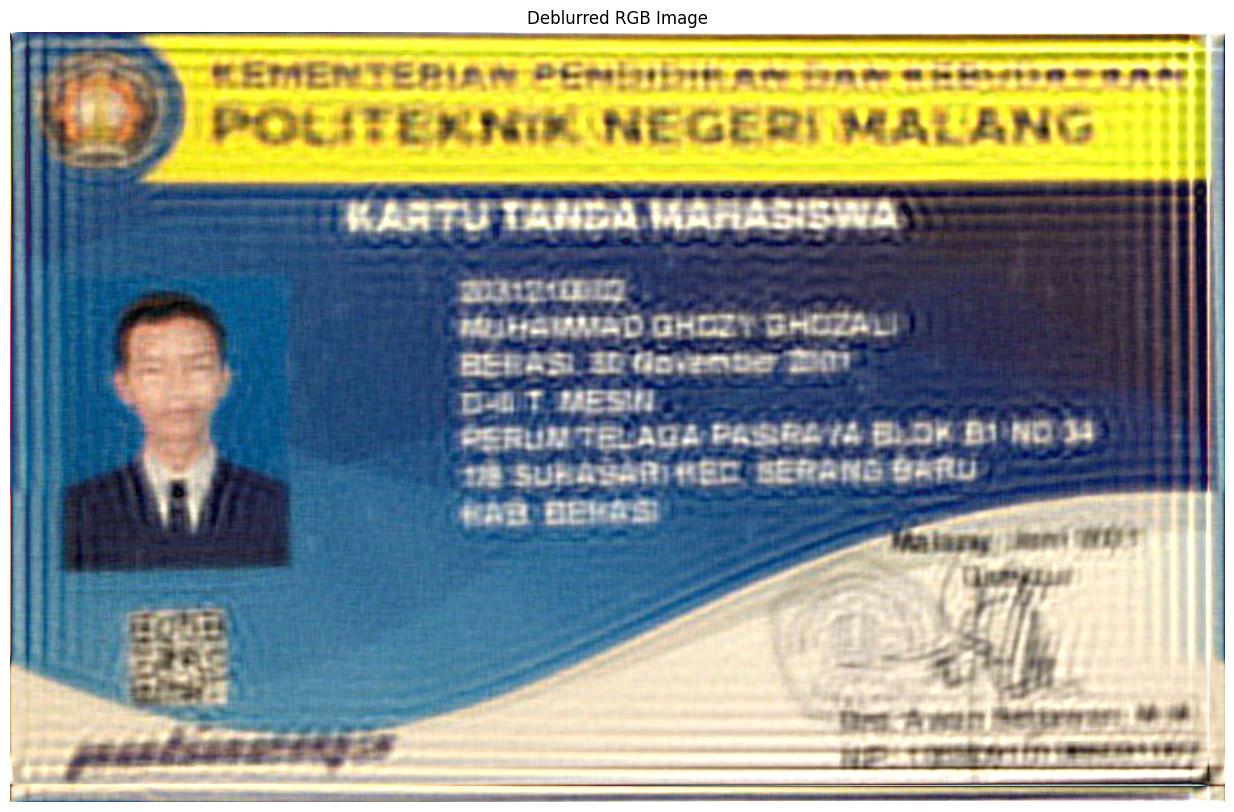

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2

def wiener_filter(img_blur, kernel, K):
    # Mengubah piksel menjadi rentang 0 hingga 1
    img_blur = img_blur / 255
    deconv_img_blur = np.copy(img_blur)
    # Mengubah ukuran kernel menjadi seperti gambar dengan cara menambahkan padding
    kernel = np.pad(kernel, [(0, deconv_img_blur.shape[0] - kernel.shape[0]), (0, deconv_img_blur.shape[1] - kernel.shape[1])], mode='constant')

    # Fourier Transform
    # fft mengubah dari domain spasial ke domain frekuensi
    img_blur = fft2(img_blur)
    kernel = fft2(kernel)
    # Wiener filter
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    deconv_img_blur = img_blur * kernel

    # ifft mengubah dari domain frekuensi ke domain spasial

    # np.abs Mengonversi hasil transformasi yang mungkin memiliki bagian imajiner 
    # menjadi nilai positif yang merepresentasikan intensitas pixel citra.
    deconv_img_blur = np.abs(ifft2(deconv_img_blur))
    # Mengubah piksel menjadi rentang 1 hingga 255
    deconv_img_blur = np.clip(deconv_img_blur * 255, 0, 255)
    return np.uint8(deconv_img_blur)


# Pisahkan gambar menjadi tiga channel warna
R, G, B = cv2.split(KTM)

# Membuat Box Blur kernel 19x19
kernel_size = 19
box_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)


# Menerapkan Wiener filter pada tiap channel
K = 0.0075
R_deblurred = wiener_filter(R, box_kernel, K)
G_deblurred = wiener_filter(G, box_kernel, K)
B_deblurred = wiener_filter(B, box_kernel, K)

# Gabungkan kembali channel yang sudah dideblur
deblurred_img = cv2.merge([R_deblurred, G_deblurred, B_deblurred])

# Visualisasi hasil
plt.figure(figsize=(30, 10))

# Gambar setelah deblurring
plt.imshow(deblurred_img)  # Pastikan tipe data sesuai untuk visualisasi
plt.title('Deblurred RGB Image')
plt.axis('off')
plt.show()


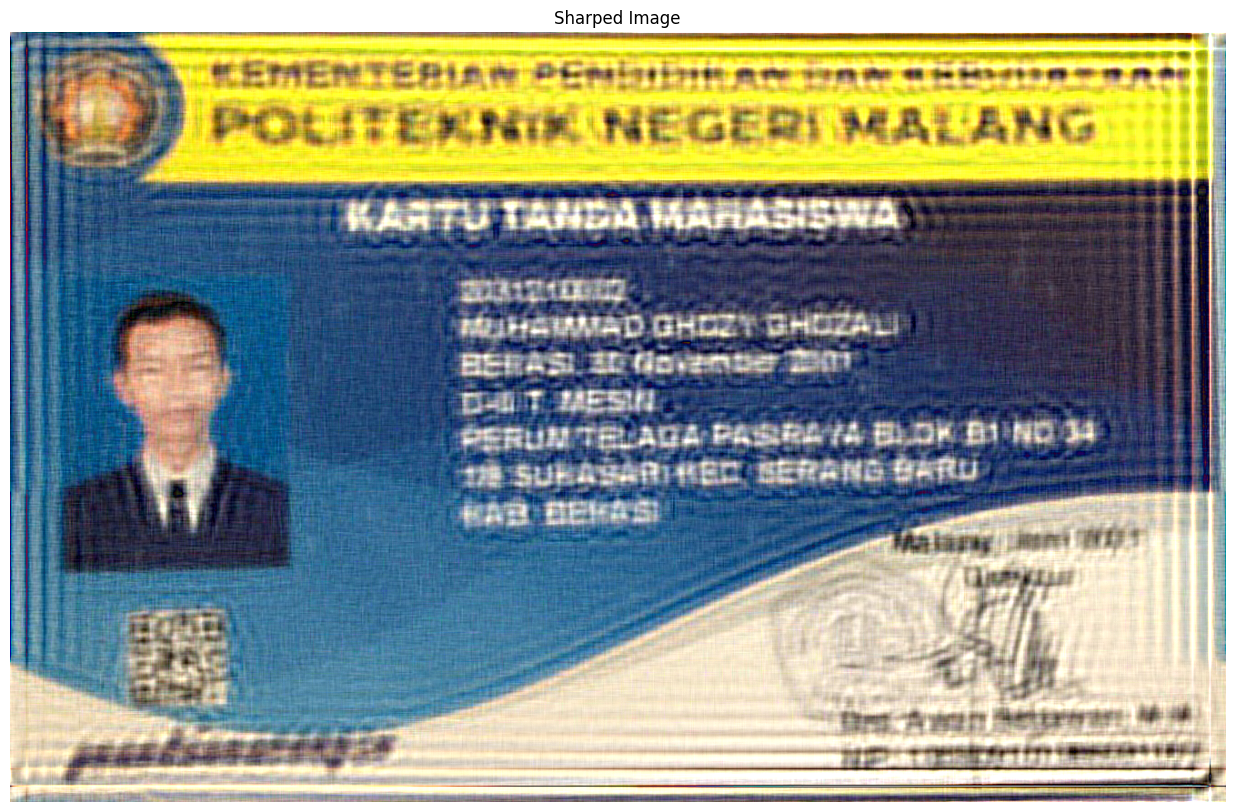

In [5]:
# Misalkan KTM adalah gambar input dan kernel_sharpen adalah kernel sharpening
final = convolution3d(deblurred_img, kernel_sharpen)

# Pastikan final berada dalam rentang [0, 255]
final = np.clip(final, 0, 255).astype(np.uint8)

plt.figure(figsize=(30, 10))
# Tampilkan gambar dengan judul
plt.imshow(final)
plt.title('Sharped Image')
plt.axis('off')  # Menyembunyikan sumbu
plt.show()

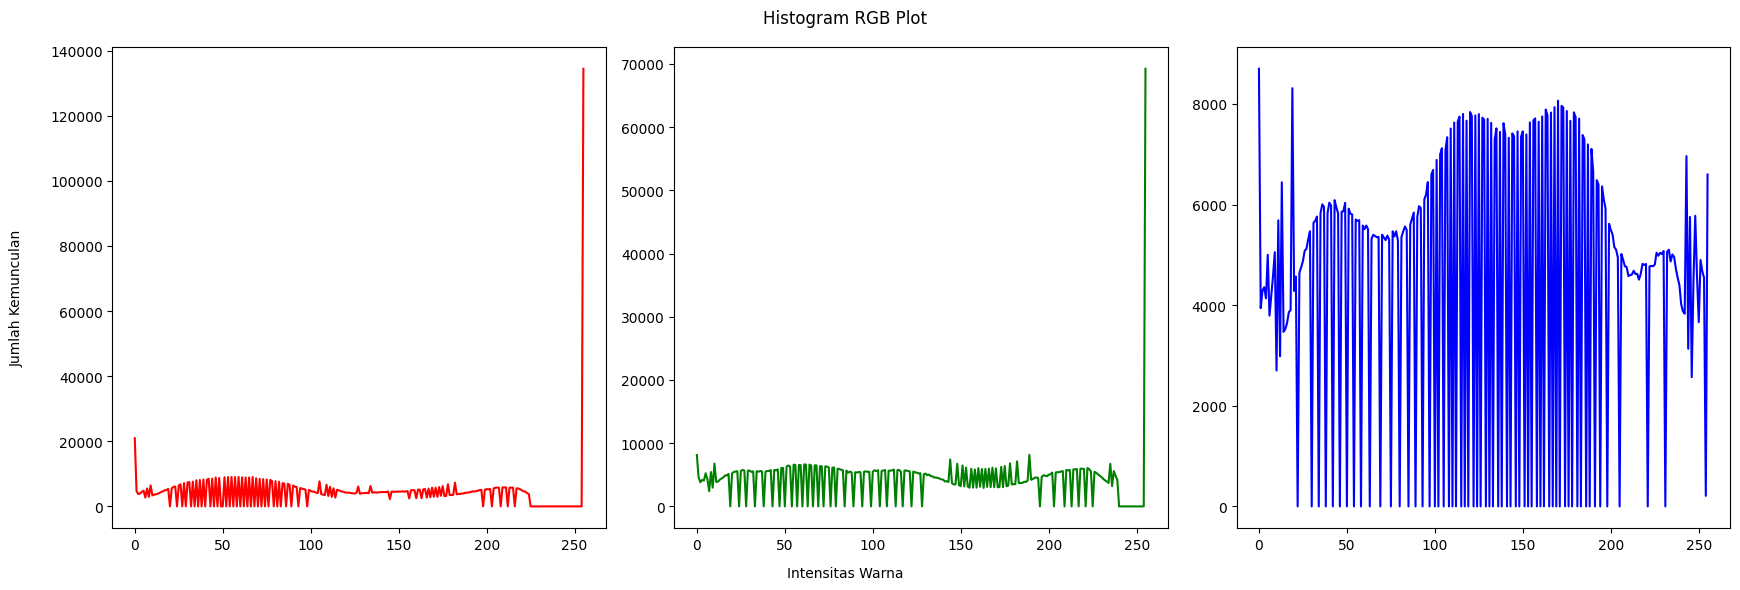

In [6]:
red_channel = final[:, :, 0]
green_channel = final[:, :, 1]
blue_channel = final[:, :, 2]



# Lakukan histogram equalization pada setiap channel
equalized_red_channel = cv2.equalizeHist(red_channel)
equalized_green_channel = cv2.equalizeHist(green_channel)
equalized_blue_channel = cv2.equalizeHist(blue_channel)

hist_red, bin_edges_red = np.histogram(equalized_red_channel, bins=256, range=(0, 256))
hist_green, bin_edges_green = np.histogram(equalized_green_channel, bins=256, range=(0, 256))
hist_blue, bin_edges_blue = np.histogram(equalized_blue_channel, bins=256, range=(0, 256))

# Membuat subplot 1 baris, 3 kolom
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot histogram merah
axs[0].plot(hist_red, color='red')
# Plot histogram hijau
axs[1].plot(hist_green, color='green')

# Plot histogram biru
axs[2].plot(hist_blue, color='blue')

# Menambahkan satu label sumbu X dan Y untuk semua plot
fig.text(0.5, 0.04, 'Intensitas Warna', ha='center', va='center')  # Label sumbu X
fig.text(0.04, 0.5, 'Jumlah Kemunculan', ha='center', va='center', rotation='vertical')  # Label sumbu Y
fig.suptitle('Histogram RGB Plot')
# Tampilkan semua plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Sesuaikan layout agar label tidak terpotong
plt.show()


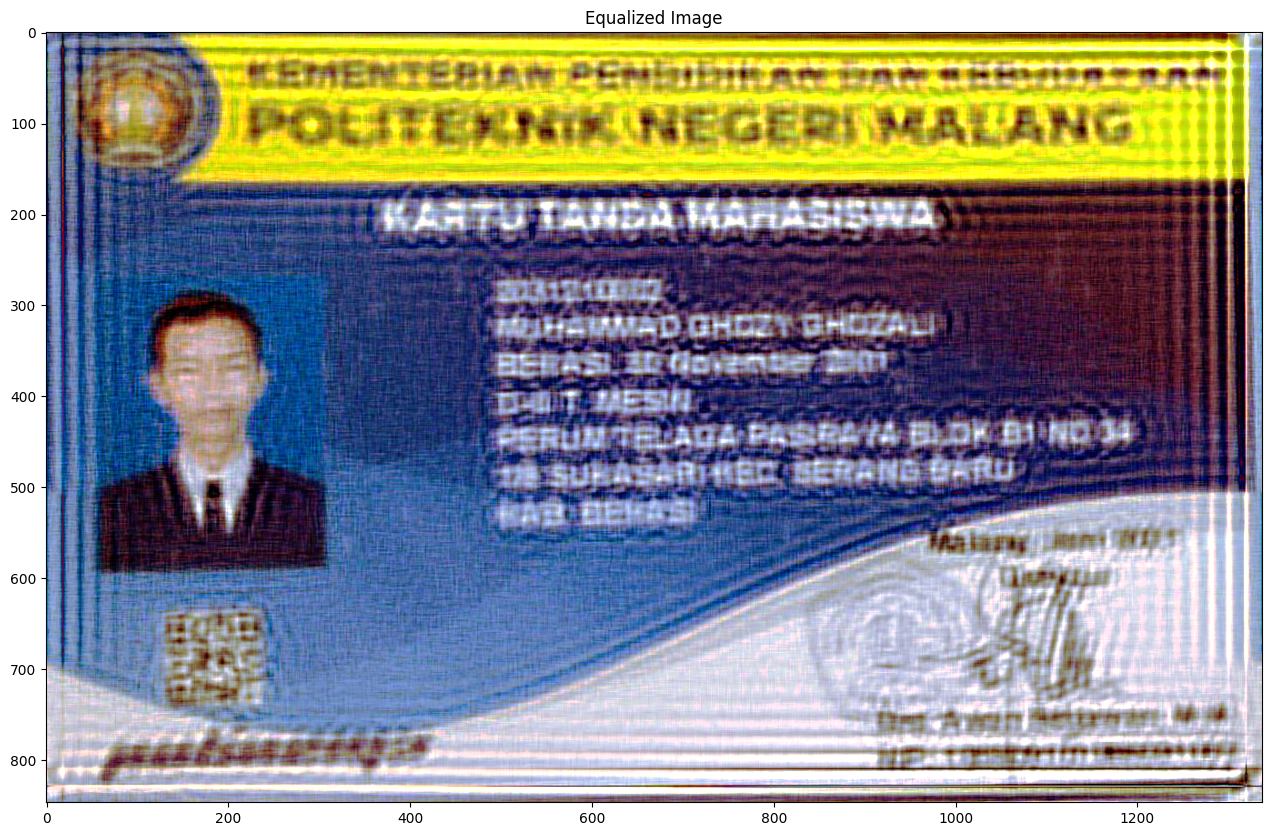

In [7]:
equalized_image = cv2.merge([equalized_red_channel, equalized_green_channel,equalized_blue_channel])
# Visualisasi hasil
plt.figure(figsize=(30, 10))

# Gambar setelah histogram equalization
plt.imshow(equalized_image)
plt.title('Equalized Image')

plt.show()